# Import images 

In [1]:
# !pip install tensorflow-macos
# !pip install tensorflow-hub
# !pip install tensorflow-datasets

In [237]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

import pandas as pd

import matplotlib.pyplot as plt


In [238]:
# Formatting the column display in jupyter labs
pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", 200)
pd.set_option('display.max_colwidth', None)

In [239]:
print(tf.__version__)

2.11.0


### move pictures to subfolders

In [240]:
# The data contains 193 different families of fish divided into 483 species of fish. 
# Classifiying only on the family level would therefore only double the number of images per class, 
# without assuring a consistent number of images per class

#file_list = pd.read_csv('data/fish_data/list.csv', header=None)
#file_list.columns = ['index_2', 'pre_folder_name', 'controlled_info', 'combined', 'pre_file_name']
#
#file_list_2 = file_list['pre_folder_name'].str.split('\_', expand=True)
#file_list_2.columns = ['family','species','subspecies']
#
#file_list = pd.concat([file_list, file_list_2], axis=0, ignore_index=True)
#
#
#file_list['file_name'] = '/Users/nlory/.keras/datasets/fish_photos/numbered/' + file_list['pre_file_name'].astype(str) + '.png'
#file_list['folder_name'] = '/Users/nlory/.keras/datasets/fish_photos/numbered/' + file_list['pre_folder_name'].astype(str) + '/'
#file_list['file_name_new'] = file_list['folder_name'].astype(str) + file_list['pre_file_name'].astype(str) + '.png'
#
#df = file_list[['file_name','folder_name', 'file_name_new', 'pre_file_name', 'pre_folder_name', 'family','species']].copy()
#df
#file_list_2
#df['family'].nunique()

### import to keras/tensorflow

[https://www.tensorflow.org/tutorials/load_data/images](https://www.tensorflow.org/tutorials/load_data/images)

In [241]:
import pathlib
from pathlib import Path

In [242]:
data_dir = Path('data/fish_data/images/numbered')


In [243]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)


4411


In [244]:
batch_size = 32
img_height = 150
img_width = 150


In [245]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 4411 files belonging to 483 classes.
Using 3529 files for training.


In [246]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 4411 files belonging to 483 classes.
Using 882 files for validation.


In [247]:
class_names = train_ds.class_names
print(class_names)

['A73EGS-P', 'CUNWCB-Y', 'Istiophorus_platypterus', 'P1ROZC-Z', 'PQV7DP-S', 'acanthaluteres_brownii', 'acanthaluteres_spilomelanurus', 'acanthaluteres_vittiger', 'acanthistius_cinctus', 'acanthopagrus_australis', 'acanthopagrus_berda', 'acanthopagrus_latus', 'achoerodus_gouldii', 'achoerodus_viridis', 'acreichthys_tomentosus', 'aesopia_cornuta', 'aethaloperca_rogaa', 'alectis_ciliaris', 'alectis_indica', 'alepes_kleinii', 'aluterus_monoceros', 'aluterus_scriptus', 'amanses_scopas', 'anampses_caeruleopunctatus', 'anampses_elegans', 'anampses_femininus', 'anampses_geographicus', 'anampses_lennardi', 'anampses_melanurus', 'anampses_meleagrides', 'anampses_neoguinaicus', 'anampses_twistii', 'anodontostoma_chacunda', 'anyperodon_leucogrammicus', 'aphareus_furca', 'aphareus_rutilans', 'aprion_virescens', 'argyrops_spinifer', 'aseraggodes_melanostictus', 'atractoscion_aequidens', 'atule_mate', 'auxis_rochei', 'auxis_thazard', 'bathylagichthys_greyae', 'beryx_decadactylus', 'bodianus_anthioide

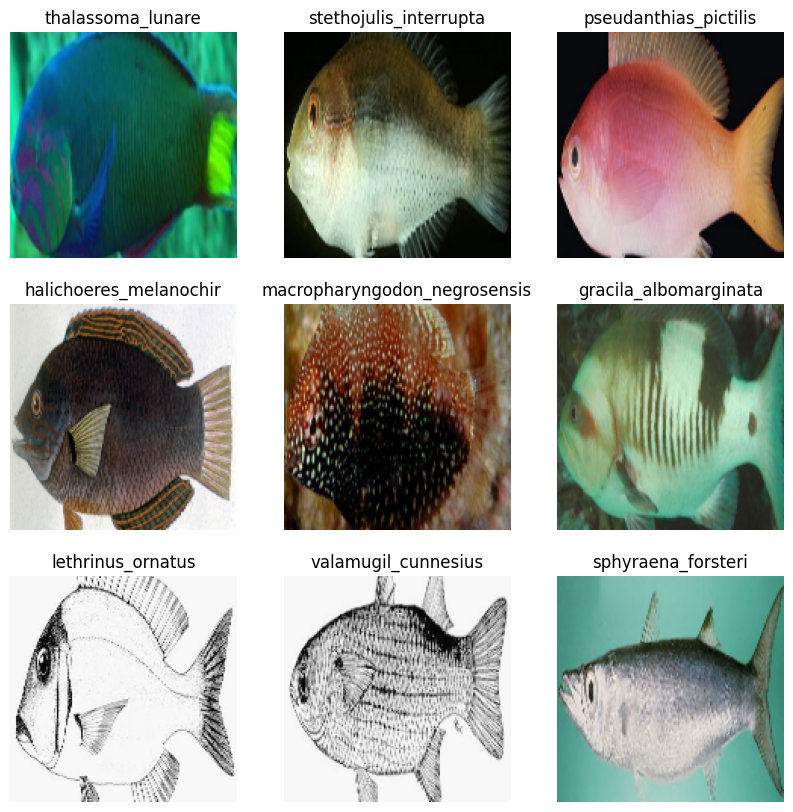

In [248]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [249]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 150, 150, 3)
(32,)


In [250]:
# normalize color values
normalization_layer = tf.keras.layers.Rescaling(1./255)


In [251]:
# optional: apply normailzation to the dataset
#normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(normalized_ds))
#first_image = image_batch[0]
## Notice the pixel values are now in `[0,1]`.
#print(np.min(first_image), np.max(first_image))


### Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

* Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
* Dataset.prefetch overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the Prefetching section of the Better performance with the tf.data API guide. [link](https://www.tensorflow.org/guide/data_performance)

In [252]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


# First test model

In [15]:
num_classes = 483

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])


In [16]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


In [17]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=6
)


Epoch 1/6
111/111 [==============================] - 28s 242ms/step - loss: 6.1633 - accuracy: 0.0028 - val_loss: 6.0992 - val_accuracy: 0.0045
Epoch 2/6
111/111 [==============================] - 26s 235ms/step - loss: 5.9066 - accuracy: 0.0091 - val_loss: 6.0509 - val_accuracy: 0.0079
Epoch 3/6
111/111 [==============================] - 25s 230ms/step - loss: 5.5646 - accuracy: 0.0295 - val_loss: 6.0842 - val_accuracy: 0.0204
Epoch 4/6
111/111 [==============================] - 25s 224ms/step - loss: 4.9116 - accuracy: 0.0961 - val_loss: 5.6601 - val_accuracy: 0.0714
Epoch 5/6
111/111 [==============================] - 25s 222ms/step - loss: 3.8721 - accuracy: 0.2270 - val_loss: 5.4976 - val_accuracy: 0.1100
Epoch 6/6
111/111 [==============================] - 25s 223ms/step - loss: 2.9019 - accuracy: 0.3777 - val_loss: 5.3865 - val_accuracy: 0.1429


### save test-model
[tutorial to save models](https://www.tensorflow.org/tutorials/keras/save_and_load)

In [18]:
# !pip install pyyaml h5py  # Required to save models in HDF5 format

In [20]:
# import os
# import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)


2.11.0


In [21]:
# save the model: 

model.save('models/230125_first_test_model')
# tf.saved_model.save(model, "models/230125_first_test_model_2")

INFO:tensorflow:Assets written to: models/230125_first_test_model/assets


INFO:tensorflow:Assets written to: models/230125_first_test_model/assets


# Converting tf.PrefetchDataset to datatype suitable for vision transformer (keras.sequential) - doesn't work

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])


In [96]:
# tf.keras.layers.RandomContrast, tf.keras.layers.RandomCrop, tf.keras.layers.RandomZoom,

IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])


data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


In [133]:
num_classes = 483

model = tf.keras.Sequential([
  # Add the preprocessing layers you created earlier.
  #resize_and_rescale,
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])


In [136]:
num_classes = 483

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])


In [137]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [138]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=12
)

Epoch 1/12
111/111 [==============================] - 27s 238ms/step - loss: 6.1327 - accuracy: 0.0062 - val_loss: 5.9813 - val_accuracy: 0.0091
Epoch 2/12
111/111 [==============================] - 26s 235ms/step - loss: 5.7629 - accuracy: 0.0201 - val_loss: 5.7326 - val_accuracy: 0.0249
Epoch 3/12
111/111 [==============================] - 25s 225ms/step - loss: 5.1584 - accuracy: 0.0669 - val_loss: 5.3968 - val_accuracy: 0.0850
Epoch 4/12
111/111 [==============================] - 26s 233ms/step - loss: 4.0553 - accuracy: 0.2154 - val_loss: 5.1295 - val_accuracy: 0.1417
Epoch 5/12
111/111 [==============================] - 29s 258ms/step - loss: 2.8631 - accuracy: 0.3908 - val_loss: 5.4840 - val_accuracy: 0.1791
Epoch 6/12
111/111 [==============================] - 26s 236ms/step - loss: 1.9794 - accuracy: 0.5506 - val_loss: 5.7011 - val_accuracy: 0.2120
Epoch 7/12
111/111 [==============================] - 26s 238ms/step - loss: 1.3765 - accuracy: 0.6704 - val_loss: 5.9328 - val_ac

In [56]:
# weird thing i found on stack overflow
def transform(image, label):
    image = tf.image.flip_left_right(image)
    return image, label

#It works well if I apply the transformation directly to the dataset. But it doesn't increase the amount of data:

#ds = ds.map(transform)

#So, I tried to create a second dataset and concatenate both:

ds0 = train_ds.map(transform)
ds = train_ds.concatenate(ds0)


In [62]:
class_names = train_ds.class_names
print(class_names)

AttributeError: 'PrefetchDataset' object has no attribute 'class_names'

In [55]:
#load dataset in to numpy array
sess = tf.compat.v1.Session()
tra=train_ds.batch(1000).make_one_shot_iterator().get_next()
train_A=np.array(sess.run(tra)[0])
print(train_A.shape)
sess.close()

AttributeError: 'BatchDataset' object has no attribute 'make_one_shot_iterator'

In [54]:
print(type(x_train))
print(type(train_ds))

<class 'numpy.ndarray'>
<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>


In [44]:


batch_size = 32

# did not work
#prefetch_dataset_train = train_ds.batch(batch_size)
#prefetch_dataset_val = val_ds.batch(batch_size)

#prefetch_dataset_train = train_ds.as_numpy_iterator()



2023-01-26 12:28:58.508454: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-01-26 12:28:58.508485: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-01-26 12:28:58.508496: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. I

# Tutorial on vision transformer - doesn't work

[transformer tutorial](https://keras.io/examples/vision/image_classification_with_vision_transformer/)

[alternative tutorial that requires different folder structure](https://www.kaggle.com/code/abhinand05/vision-transformer-vit-tutorial-baseline)

In [22]:
# !pip install -U tensorflow-addons

In [22]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa


In [26]:
# example dataset from tutorial
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [86]:
# Configure the hyperparameters
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


In [87]:
data_augmentation = keras.Sequential(
    [
        #layers.Normalization(),
        #layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
# data_augmentation.layers[0].adapt()




In [88]:
# Implement multilayer perceptron (MLP)
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


In [89]:
# Implement patch creation as a layer
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


[geeksforgeeks page](https://www.geeksforgeeks.org/python-image-classification-using-keras/)

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


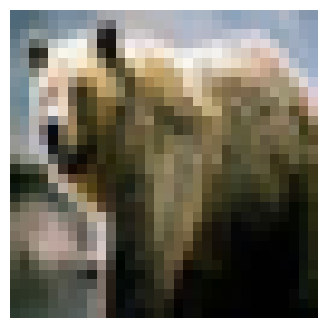

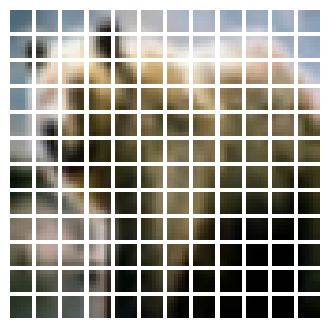

In [90]:
# Let's display patches for a sample image

import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")


In [91]:
# Implement the patch encoding layer
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


In [92]:
# Build the ViT model
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


In [93]:
# Compile, train, and evaluate the model
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


Epoch 1/100


InvalidArgumentError: Graph execution error:

Detected at node 'gradient_tape/model_1/patch_encoder_1/add/BroadcastGradientArgs' defined at (most recent call last):
    File "/Users/nlory/.pyenv/versions/3.9.8/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/nlory/.pyenv/versions/3.9.8/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/Users/nlory/.pyenv/versions/3.9.8/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
      self._run_once()
    File "/Users/nlory/.pyenv/versions/3.9.8/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
      handle._run()
    File "/Users/nlory/.pyenv/versions/3.9.8/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2945, in run_cell
      result = self._run_cell(
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3000, in _run_cell
      return runner(coro)
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3203, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3382, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3442, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/td/j171mgyn3cvbndk8r221w_9w0000gn/T/ipykernel_73945/352168860.py", line 42, in <module>
      history = run_experiment(vit_classifier)
    File "/var/folders/td/j171mgyn3cvbndk8r221w_9w0000gn/T/ipykernel_73945/352168860.py", line 24, in run_experiment
      history = model.fit(
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/tensorflow_addons/optimizers/weight_decay_optimizers.py", line 168, in minimize
      return super().minimize(
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/optimizer_v2.py", line 585, in minimize
      grads_and_vars = self._compute_gradients(
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/optimizer_v2.py", line 643, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/optimizer_v2.py", line 519, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/model_1/patch_encoder_1/add/BroadcastGradientArgs'
Incompatible shapes: [256,25,64] vs. [144,64]
	 [[{{node gradient_tape/model_1/patch_encoder_1/add/BroadcastGradientArgs}}]] [Op:__inference_train_function_57220]

# transfer learning but bad

In [182]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [183]:

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(483, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')


In [150]:
#model.summary()

In [151]:

# train the model on the new data for a few epochs
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy') # , label_mode='categorical'

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3


ValueError: in user code:

    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/keras/losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/keras/losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/keras/losses.py", line 2004, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/keras/backend.py", line 5532, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 483) are incompatible


In [153]:
#ImageNet classes with ResNet50

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

model = ResNet50(weights='imagenet')

img_path = 'elephant.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])
# Predicted: [(u'n02504013', u'Indian_elephant', 0.82658225), (u'n01871265', u'tusker', 

102967424/102967424 [==============================] - 103s 1us/step


FileNotFoundError: [Errno 2] No such file or directory: 'elephant.jpg'

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

model = VGG16(weights='imagenet', include_top=False)

img_path = 'elephant.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

features = model.predict(x)


# transfer learning - doesn't work

In [279]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

base_model.trainable = False



In [280]:
# train a base model

inputs = keras.Input(shape=(150, 150, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)


In [281]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]


In [282]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])
model.fit(train_ds, epochs=20, callbacks=my_callbacks, validation_data=val_ds)


Epoch 1/20


ValueError: in user code:

    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/keras/losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/keras/losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/keras/losses.py", line 2176, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/keras/backend.py", line 5680, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 1) vs (None, 483)).


In [ ]:
# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

# Train end-to-end. Be careful to stop before you overfit!
model.fit(new_dataset, epochs=10, callbacks=..., validation_data=...)


In [ ]:
# Create base model
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False)
# Freeze base model
base_model.trainable = False

# Create new model on top.
inputs = keras.Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = keras.optimizers.Adam()

# Iterate over the batches of a dataset.
for inputs, targets in new_dataset:
    # Open a GradientTape.
    with tf.GradientTape() as tape:
        # Forward pass.
        predictions = model(inputs)
        # Compute the loss value for this batch.
        loss_value = loss_fn(targets, predictions)

    # Get gradients of loss wrt the *trainable* weights.
    gradients = tape.gradient(loss_value, model.trainable_weights)
    # Update the weights of the model.
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))


# tensorflow transfer learning - Xception with weights="imagenet",

[https://www.tensorflow.org/guide/keras/transfer_learning](https://www.tensorflow.org/guide/keras/transfer_learning)

### load data with 'label_mode='categorical','

In [273]:
import pathlib
from pathlib import Path

In [274]:
data_dir = Path('data/fish_data/images/numbered')


In [283]:
batch_size = 32
img_height = 150
img_width = 150


In [284]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  label_mode='categorical',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 4411 files belonging to 483 classes.
Using 3529 files for training.


In [285]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  label_mode='categorical',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 4411 files belonging to 483 classes.
Using 882 files for validation.


In [313]:
class_names = train_ds.class_names
print(len(class_names))
print(class_names)

483
['A73EGS-P', 'CUNWCB-Y', 'Istiophorus_platypterus', 'P1ROZC-Z', 'PQV7DP-S', 'acanthaluteres_brownii', 'acanthaluteres_spilomelanurus', 'acanthaluteres_vittiger', 'acanthistius_cinctus', 'acanthopagrus_australis', 'acanthopagrus_berda', 'acanthopagrus_latus', 'achoerodus_gouldii', 'achoerodus_viridis', 'acreichthys_tomentosus', 'aesopia_cornuta', 'aethaloperca_rogaa', 'alectis_ciliaris', 'alectis_indica', 'alepes_kleinii', 'aluterus_monoceros', 'aluterus_scriptus', 'amanses_scopas', 'anampses_caeruleopunctatus', 'anampses_elegans', 'anampses_femininus', 'anampses_geographicus', 'anampses_lennardi', 'anampses_melanurus', 'anampses_meleagrides', 'anampses_neoguinaicus', 'anampses_twistii', 'anodontostoma_chacunda', 'anyperodon_leucogrammicus', 'aphareus_furca', 'aphareus_rutilans', 'aprion_virescens', 'argyrops_spinifer', 'aseraggodes_melanostictus', 'atractoscion_aequidens', 'atule_mate', 'auxis_rochei', 'auxis_thazard', 'bathylagichthys_greyae', 'beryx_decadactylus', 'bodianus_anthi

### maybe working transfer learning

In [320]:
print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(val_ds)
)
# print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))


Number of training samples: 111
Number of validation samples: 28


In [321]:
# use to one hot encode classes?! tensorflow.keras.utils.to_categorical

In [322]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)


In [323]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(483)(x)
model = keras.Model(inputs, outputs)

model.summary()


Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 sequential_25 (Sequential)  (None, 150, 150, 3)       0         
                                                                 
 rescaling_23 (Rescaling)    (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_22  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_45 (Dropout)        (None, 2048)              0         
                                                          

In [324]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss= keras.losses.CategoricalCrossentropy(from_logits=False), #reduction=losses_utils.ReductionV2.AUTO,
    metrics=[keras.metrics.CategoricalAccuracy()],
)

epochs = 20


model.fit(train_ds, epochs=epochs, validation_data=val_ds)


Epoch 1/2


111/111 [==============================] - 69s 604ms/step - loss: 9.6924 - categorical_accuracy: 0.0096 - val_loss: 10.5153 - val_categorical_accuracy: 0.0136
Epoch 2/2
111/111 [==============================] - 62s 556ms/step - loss: 10.2074 - categorical_accuracy: 0.0235 - val_loss: 9.8402 - val_categorical_accuracy: 0.0147


In [325]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.CategoricalAccuracy()],
)

epochs = 10
# epochs = 2

model.fit(train_ds, epochs=epochs, validation_data=val_ds)


Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 sequential_25 (Sequential)  (None, 150, 150, 3)       0         
                                                                 
 rescaling_23 (Rescaling)    (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_22  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_45 (Dropout)        (None, 2048)              0         
                                                          

111/111 [==============================] - 240s 2s/step - loss: 6.5414 - categorical_accuracy: 0.0128 - val_loss: 6.1850 - val_categorical_accuracy: 0.0023
Epoch 2/2
111/111 [==============================] - 227s 2s/step - loss: 6.1687 - categorical_accuracy: 0.0088 - val_loss: 6.1774 - val_categorical_accuracy: 0.0034


In [326]:
model.summary()

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 sequential_25 (Sequential)  (None, 150, 150, 3)       0         
                                                                 
 rescaling_23 (Rescaling)    (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_22  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_45 (Dropout)        (None, 2048)              0         
                                                          

In [319]:
# save the model: 

model.save('models/230127_transfer_learning_model')


INFO:tensorflow:Assets written to: models/230127_transfer_learning_model/assets


INFO:tensorflow:Assets written to: models/230127_transfer_learning_model/assets


# Try other base models

[https://keras.io/api/applications/#usage-examples-for-image-classification-models](https://keras.io/api/applications/#usage-examples-for-image-classification-models)